## Import

In [52]:
import geopandas as gpd
import pandas as pd
import numpy as np
import ipyparallel as ipp
import matplotlib.pyplot as plt
import folium 
import requests
import json
import time

## Utils

### Car distance

In [37]:
# Start a local IPython cluster using the ipcluster command in a terminal window. 
# python -m ipyparallel.engine
# python -m ipyparallel.controller

In [3]:
client = ipp.Client()
lb_view = client.load_balanced_view()

In [4]:
@lb_view.parallel(block=True)
def car_distance_parallel(x,y):
    import requests
    import json
    
    lat_1, lon_1 = x
    lat_2, lon_2 = y

    # print(f'x:\n{x}\ny:\n{y}\n')

    # call the OSMR API
    r = requests.get(f"http://router.project-osrm.org/route/v1/car/{lon_1},{lat_1};{lon_2},{lat_2}?overview=false""")
    # then you load the response using the json libray
    # by default you get only one alternative so you access 0-th element of the `routes`
    routes = json.loads(r.content)
    route_1 = routes.get("routes")[0]

    return route_1['distance']

#car_distance = np.vectorize(car_distance, signature='(n),(n)->()')

In [171]:
def car_distance(x,y):
    
    lat_1, lon_1 = x
    lat_2, lon_2 = y

    # print(f'x:\n{x}\ny:\n{y}\n')

    # call the OSMR API
    r = requests.get(f"http://router.project-osrm.org/route/v1/car/{lon_1},{lat_1};{lon_2},{lat_2}?overview=false""")
    # then you load the response using the json libray
    # by default you get only one alternative so you access 0-th element of the `routes`
    routes = json.loads(r.content)
    route_1 = routes.get("routes")[0]

    return route_1['distance']

car_distance = np.vectorize(car_distance, signature='(n),(n)->()')

### Gon algorithm implementation

In [193]:
def max_dist_point(V, C):
    max_dist = 0
    max_dist_point = None
    
    distance_matrix = pd.Series(V).apply(lambda x: car_distance(x, C))
    
    min_point_dist = distance_matrix.apply(lambda x: np.min(x))
    max_index = min_point_dist.argmax()
    max_dist_point = V[max_index]
    max_dist = min_point_dist[max_index]
            
    return max_dist_point, max_dist

In [217]:
def global_iteration(C, V, k):
    print(C)
    for i in range(k-1):
        # find the point in V that is the farthest from the set C
        # print time for each iteration to see the progress of the algorithm 
        ci, di = max_dist_point(V, C)
        C.append(ci)
        
    cmax, dmax = max_dist_point(V, C)
        
    return dmax

In [229]:
def gon(k, V: pd.Series, type="standard", n_trial=None):
    
    np.random.seed(1783297)
    
    if type == "standard":
        C = []
        
        init = np.random.randint(0, len(V))
        C.append(V[init])
        
        t1 = time.time()
        opt_distance = global_iteration(C, V, k)
        t2 = time.time()
        
        print(f'time: {t2-t1}')
            
    elif type == "plus" and n_trial > 0  and n_trial <= len(V) :
        C_l = []
        d = []
        
        init = np.random.randint(0, len(V), n_trial)
        
        for i in range(n_trial):
            C_l.append([])
            C_l[i].append(V[init[i]])
            
            t1 = time.time()
            d.append(global_iteration(C_l[i], V, k))
            t2 = time.time()
        
            print(f'iteration {i} time: {t2-t1}')
        
        opt_distance = np.min(d)
        C = C_l[np.argmin(d)]
        
    else:
        return "invalid init"
    
    return C, opt_distance

## Data preparation

### Shapefile reading

In [25]:
# Set filepath
# fp = "/workspaces/codespaces-jupyter/data/North California/gis_osm_transport_free_1.shp"
fp = 'data/North California/gis_osm_transport_free_1.shp'
transport_locations = gpd.read_file(fp)

In [26]:
# Set filepath
# fp = "/workspaces/codespaces-jupyter/data/County of Santa Clara/geo_export_742a7eac-9364-4734-a083-fd8f554cf8ca.shp"
fp = "data/County of Santa Clara/geo_export_742a7eac-9364-4734-a083-fd8f554cf8ca.shp"
santa_clara_county_boundaries = gpd.read_file(fp)

### Data exploration

In [12]:
type(transport_locations)

geopandas.geodataframe.GeoDataFrame

In [13]:
print(transport_locations.crs)

EPSG:4326


In [14]:
transport_locations.head(10)

,osm_id,code,fclass,name,geometry
0,30236493,5601,railway_station,San Antonio,POINT (-122.10724 37.40741)
1,30236612,5601,railway_station,Mountain View,POINT (-122.07588 37.39434)
2,53023702,5601,railway_station,Rockridge,POINT (-122.25126 37.84476)
3,57792672,5601,railway_station,Concord,POINT (-122.02907 37.97378)
4,57810647,5601,railway_station,Richmond,POINT (-122.35360 37.93687)
5,62538047,5602,railway_halt,Pantano,POINT (-121.88384 38.13803)
6,87362056,5602,railway_halt,Latrobe,POINT (-120.98695 38.56290)
7,90138751,5621,bus_stop,NaN,POINT (-121.31281 38.77474)
8,90408338,5602,railway_halt,Hampton,POINT (-121.11106 38.64463)
9,95327721,5601,railway_station,Ashby,POINT (-122.26971 37.85298)


In [15]:
print("BEFORE:", santa_clara_county_boundaries.crs)

santa_clara_county_boundaries = santa_clara_county_boundaries.to_crs(epsg= 4326)

print("AFTER:", santa_clara_county_boundaries.crs)

BEFORE: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
AFTER: EPSG:4326


In [16]:
santa_clara_county_boundaries

,acres,objectid,shape_area,shape_leng,sq_miles,y,geometry
0,835109.926034,2.0,3.637739e+10,1.132440e+06,1304.85926,Y,"POLYGON ((-121.74467 37.48386, -121.70037 37.4..."


<Axes: >

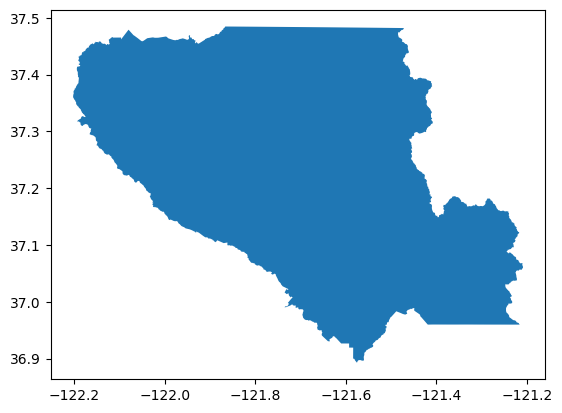

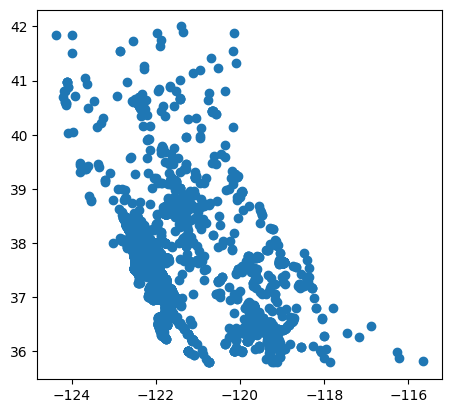

In [18]:
santa_clara_county_boundaries.plot()
transport_locations.plot()

### Santa clara data extraction

In [19]:
# take transport location within santa clara county boundaries
%time transport_location_is_in_santa_clara = transport_locations.apply(lambda x: gpd.GeoSeries(x.geometry, crs=4326).within(santa_clara_county_boundaries), axis=1)

CPU times: total: 37.1 s
Wall time: 1min 11s


In [20]:
transport_locations['transport_location_is_in_santa_clara'] = transport_location_is_in_santa_clara

In [21]:
transport_location_is_in_santa_clara.value_counts()

False    17601
True      3619
Name: count, dtype: int64

In [22]:
santa_clara_transport_locations = transport_locations.where(transport_locations.transport_location_is_in_santa_clara == True) \
.dropna() \
.drop(labels='transport_location_is_in_santa_clara', axis=1)

In [23]:
santa_clara_transport_locations

,osm_id,code,fclass,name,geometry
0,30236493,5601.0,railway_station,San Antonio,POINT (-122.10724 37.40741)
1,30236612,5601.0,railway_station,Mountain View,POINT (-122.07588 37.39434)
16,266800225,5621.0,bus_stop,El Camino Real & East Remington Drive,POINT (-122.02439 37.36102)
18,266910711,5601.0,railway_station,Capitol,POINT (-121.84176 37.28397)
19,266944543,5601.0,railway_station,Morgan Hill,POINT (-121.65053 37.12970)
...,...,...,...,...,...
20503,9632354205,5621.0,bus_stop,Bus Stop #2,POINT (-121.92957 37.37230)
20504,9632354206,5621.0,bus_stop,Bus Stop #3,POINT (-121.92775 37.37190)
20505,9632354207,5621.0,bus_stop,Bus Stop #4,POINT (-121.92854 37.37317)
20506,9632354208,5621.0,bus_stop,Bus Stop #5,POINT (-121.92973 37.37373)


### Save santa clara data

In [43]:
santa_clara_transport_locations.to_file("data/County of Santa Clara/santa_clara_transport_free.geojson", driver='GeoJSON')

## Santa clara dataset

### Read santa clara data

In [8]:
santa_clara_transport_locations = gpd.read_file("data/County of Santa Clara/santa_clara_transport_free.geojson")

In [9]:
santa_clara_transport_locations.fclass.unique()

array(['railway_station', 'bus_stop', 'bus_station', 'helipad',
       'railway_halt', 'taxi'], dtype=object)

### Data visualization

In [10]:
# Create a geometry list from the GeoDataFrame
geo_df_list = [tuple([point.xy[1][0], point.xy[0][0]]) for point in santa_clara_transport_locations.geometry]

In [11]:
# OpenStreetMap
map_ = folium.Map(location=[37.335480, -121.893028], tiles="OpenStreetMap", zoom_start=10)
for point in range(len(santa_clara_transport_locations)):
    folium.Circle(geo_df_list[point]).add_to(map_)
map_

### Work on a sample

In [157]:
n = 15
santa_clara_transport_locations_sample = santa_clara_transport_locations.sample(n, random_state=1783297)

<Axes: >

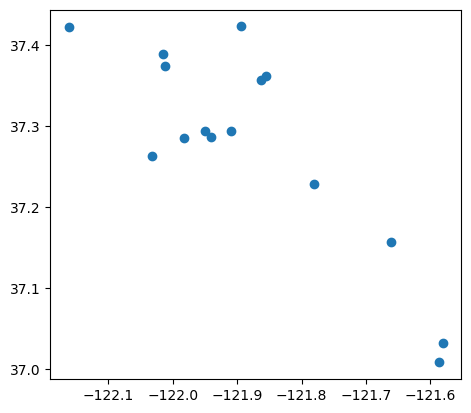

In [158]:
santa_clara_transport_locations_sample.plot()

In [159]:
# Create a geometry list from the GeoDataFrame
geo_df_list_sample = [[point.xy[1][0], point.xy[0][0]] for point in santa_clara_transport_locations_sample.geometry]

In [206]:
# OpenStreetMap
map_ = folium.Map(location=[37.335480, -121.893028], tiles="OpenStreetMap", zoom_start=10)
for point in range(len(santa_clara_transport_locations_sample)):
    folium.Circle(geo_df_list_sample[point], radius = 200).add_to(map_)
map_

#### Simple Gon

In [230]:
C, d  = gon(3, pd.Series(geo_df_list_sample))

[[37.4232065, -121.8935023]]
time: 44.661184310913086


In [231]:
C, d

([[37.4232065, -121.8935023],
  [37.0077962, -121.5868655],
  [37.2633018, -122.0318024]],
 26750.1)

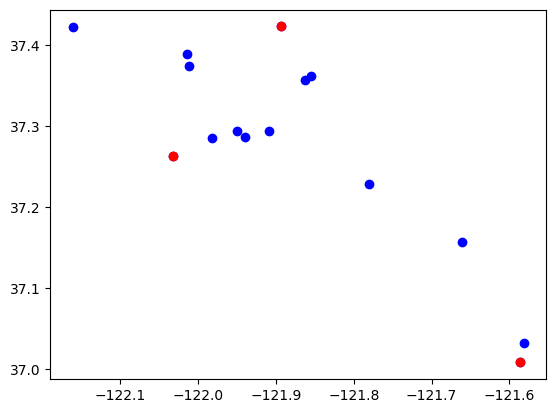

In [233]:
plt.scatter([x for x in np.array(geo_df_list_sample)[:,1]], [x for x in np.array(geo_df_list_sample)[:,0]], c = 'blue')
plt.scatter([x for x in np.array(C)[:,1]], [x for x in np.array(C)[:,0]], c = 'red')

#### Almoast Gon+

In [234]:
C_plus, d_plus = gon(3, pd.Series(geo_df_list_sample), type="plus", n_trial=5)

[[37.4232065, -121.8935023]]
iteration 0 time: 44.611757040023804
[[37.286989, -121.9401152]]
iteration 1 time: 44.99263906478882
[[37.1573146, -121.6609981]]
iteration 2 time: 44.99330949783325
[[37.2633018, -122.0318024]]
iteration 3 time: 44.99452328681946
[[37.2942575, -121.9091985]]
iteration 4 time: 45.00018262863159


In [235]:
C_plus, d_plus

([[37.286989, -121.9401152],
  [37.0077962, -121.5868655],
  [37.4229543, -122.1609624]],
 22802.2)

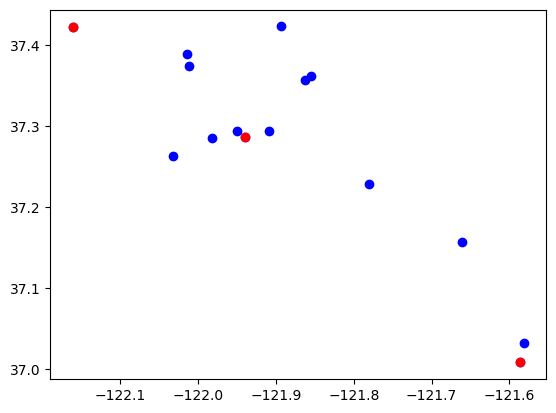

In [236]:
plt.scatter([x for x in np.array(geo_df_list_sample)[:,1]], [x for x in np.array(geo_df_list_sample)[:,0]], c = 'blue')
plt.scatter([x for x in np.array(r)[:,1]], [x for x in np.array(r)[:,0]], c = 'red')

# End